# QC Application

## Median Filter

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# --- Step 1: Initial Load and Inspection ---
file_name = '25bspr2a_s16_0001m.filtered.csv'
df = pd.read_csv(file_name) # This line assumes the file is accessible in the current environment

# choose variable
data_var = 'oxy_percentsat'

# Convert 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])
print(df.isnull().sum())

# --- Step 2: Clean Conductivity < 0.001 and Propagate NaNs ---
df_cleaned = df.copy()

# Replace conductivity and salinity values with NaN where conductivity is less than 0.001
# As discussed, salinity is also made NaN due to its correlation with anomalous conductivity
df_cleaned.loc[df_cleaned['conductivity'] < 0.01, ['conductivity', 'salinity']] = float('nan')

# Propagate NaNs from conductivity to temperature
# df_cleaned.loc[df_cleaned['conductivity'].isnull(), 'temperature'] = float('nan')
print(df_cleaned.isnull().sum())

# --- Step 3: Rolling Filter for Outliers in Conductivity ---

# Set the 'time' column as the index for rolling operations
df_cleaned_indexed = df_cleaned.set_index('time')

# Store original conductivity (after initial cleaning) for comparison in the next plot
original_conductivity_for_rolling_plot = df_cleaned_indexed[data_var].copy()

# Define the rolling window size (5 days)
window_size = '7D'

# Calculate rolling mean and standard deviation for conductivity
df_cleaned_indexed['salinity_rolling_mean'] = df_cleaned_indexed[data_var].rolling(window=window_size).mean()
df_cleaned_indexed['salinity_rolling_std'] = df_cleaned_indexed[data_var].rolling(window=window_size).std()

# Define outlier bounds (5 standard deviations)
num_std_dev = 5
df_cleaned_indexed['upper_bound'] = df_cleaned_indexed['salinity_rolling_mean'] + num_std_dev * df_cleaned_indexed['salinity_rolling_std']
df_cleaned_indexed['lower_bound'] = df_cleaned_indexed['salinity_rolling_mean'] - num_std_dev * df_cleaned_indexed['salinity_rolling_std']

# Mark outliers: Replace conductivity values that are outside the bounds with NaN
outlier_mask = (df_cleaned_indexed[data_var] > df_cleaned_indexed['upper_bound']) | \
               (df_cleaned_indexed[data_var] < df_cleaned_indexed['lower_bound'])

df_cleaned_indexed.loc[outlier_mask, data_var] = float('nan')
print(df_cleaned_indexed.isnull().sum())

# Reset index to get 'time' back as a column for plotting
df_cleaned_final = df_cleaned_indexed.reset_index()

Unnamed: 0.8               0
time                       0
Unnamed: 0.7               0
Unnamed: 0.6               0
Unnamed: 0.5               0
Unnamed: 0.4               0
Unnamed: 0.3               0
Unnamed: 0.2               0
Unnamed: 0.1               0
Unnamed: 0                 0
depth                      0
latitude                   0
longitude                  0
temperature                0
conductivity               0
salinity                 127
oxy_conc                  14
oxy_temperature            0
oxy_percentsat             5
oxy_conc_umkg             14
salinity_rolling_mean      0
salinity_rolling_std       1
upper_bound                1
lower_bound                1
dtype: int64
Unnamed: 0.8               0
time                       0
Unnamed: 0.7               0
Unnamed: 0.6               0
Unnamed: 0.5               0
Unnamed: 0.4               0
Unnamed: 0.3               0
Unnamed: 0.2               0
Unnamed: 0.1               0
Unnamed: 0                 0
d


Quality control process completed for the new file.


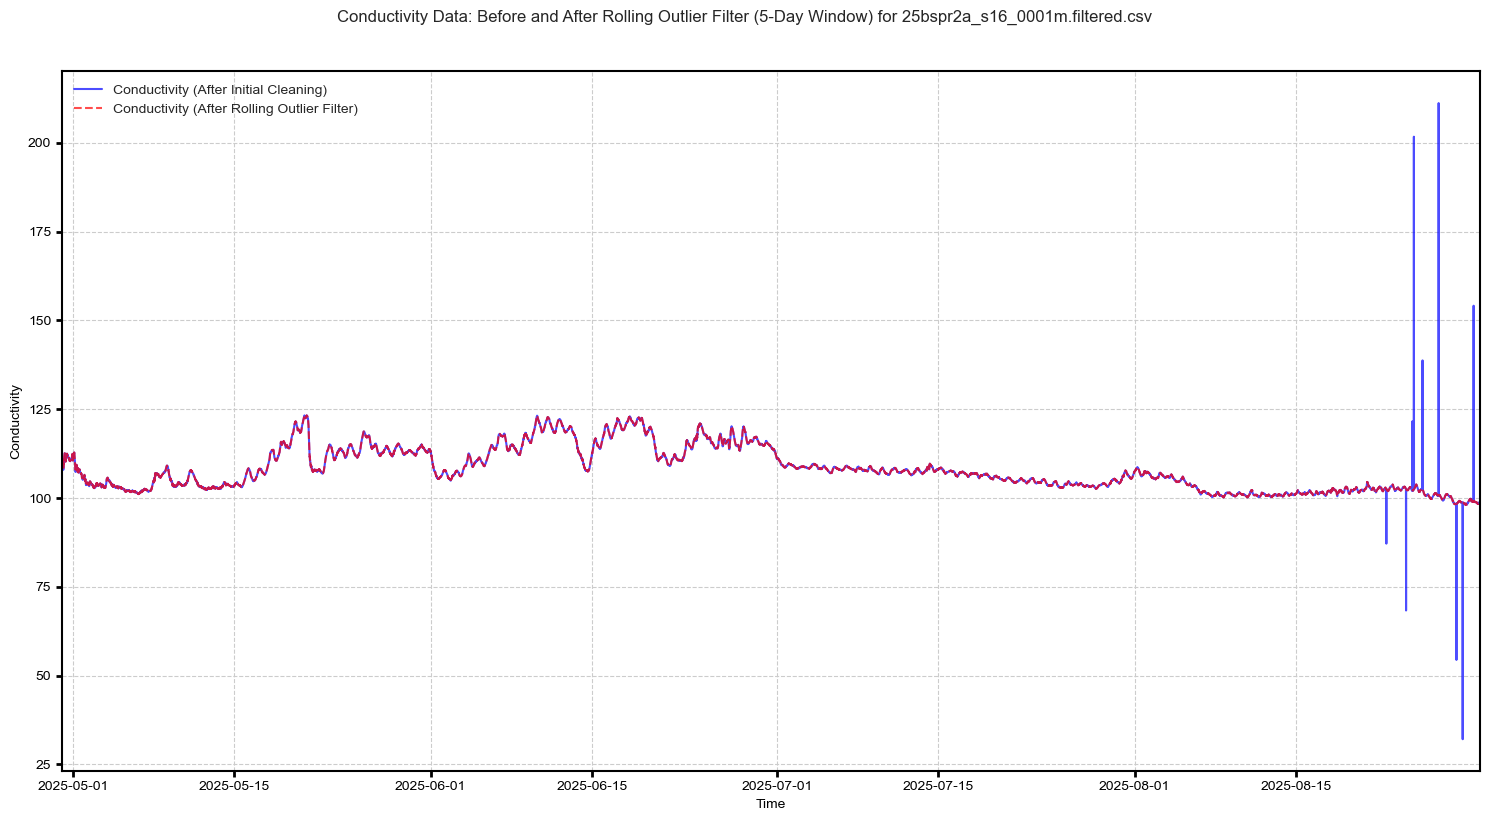

In [74]:
# Plot: Conductivity before and after rolling filter
fig2, ax2 = plt.subplots(figsize=(15, 8))
fig2.suptitle(f'Conductivity Data: Before and After Rolling Outlier Filter (5-Day Window) for {file_name}', y=1.02)

ax2.plot(df_cleaned_final['time'], original_conductivity_for_rolling_plot.reset_index()[data_var],
         label='Conductivity (After Initial Cleaning)', color='blue', alpha=0.7)
ax2.plot(df_cleaned_final['time'], df_cleaned_final[data_var],
         label='Conductivity (After Rolling Outlier Filter)', color='red', linestyle='--', alpha=0.7)
# ax2.set_ylim([31.5,32.2])
ax2.set_xlim([df_cleaned.time.min(),df_cleaned.time.max()])
ax2.set_xlabel('Time')
ax2.set_ylabel('Conductivity')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.savefig('images/rolling_outlier_plot_25bspr2a_s16_0001m.png')
# plt.close(fig2) # This line was used to close the figure and free memory in the execution environment

print("\nQuality control process completed for the new file.")

In [75]:
# df_cleaned_final.to_csv(file_name.replace('trimmed','filtered'))
#or
df_cleaned_final.to_csv(file_name)

In [77]:
import pandas as pd
import xarray as xr
import datetime
import EcoFOCIpy.io.erddap as erddap

#wrap the plot in image settings for visual appeal
# may be able to make this cleaner or just a preset
%run '../../../settings/mpl_plot_settings.py'

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker


<Figure size 640x480 with 0 Axes>

In [78]:
dep_details = {'url':"http://ecofoci-field.pmel.noaa.gov:8082/erddap",
               'cruiseid':'dy2504',
               'qclevel':'preliminary',
               'concastno':'022'
              }

rec_details = {'url':"http://ecofoci-field.pmel.noaa.gov:8082/erddap",
               'cruiseid':'dy2508',
               'qclevel':'preliminary',
               'concastno':'000'
              }
               
depcast = erddap.erddapCTDretrieve(**dep_details)
# reccast = erddap.erddapCTDretrieve(**rec_details)

some variable names switch between preliminary and final... this will eventually be resolved

In [79]:
#drop units from names
depcast.columns = [x.split()[0] for x in depcast.columns]
# reccast.columns = [x.split()[0] for x in reccast.columns]

In [80]:
df_cleaned_final = df_cleaned_final.set_index('time')

/var/folders/6r/n_mpcj7d7pdf9ncqvjy5vb8c0000jm/T/ipykernel_9707/173948837.py:6: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax[0].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
/var/folders/6r/n_mpcj7d7pdf9ncqvjy5vb8c0000jm/T/ipykernel_9707/173948837.py:20: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax[1].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
/var/folders/6r/n_mpcj7d7pdf9ncqvjy5vb8c0000jm/T/ipykernel_9707/173948837.py:34: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax[2].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),


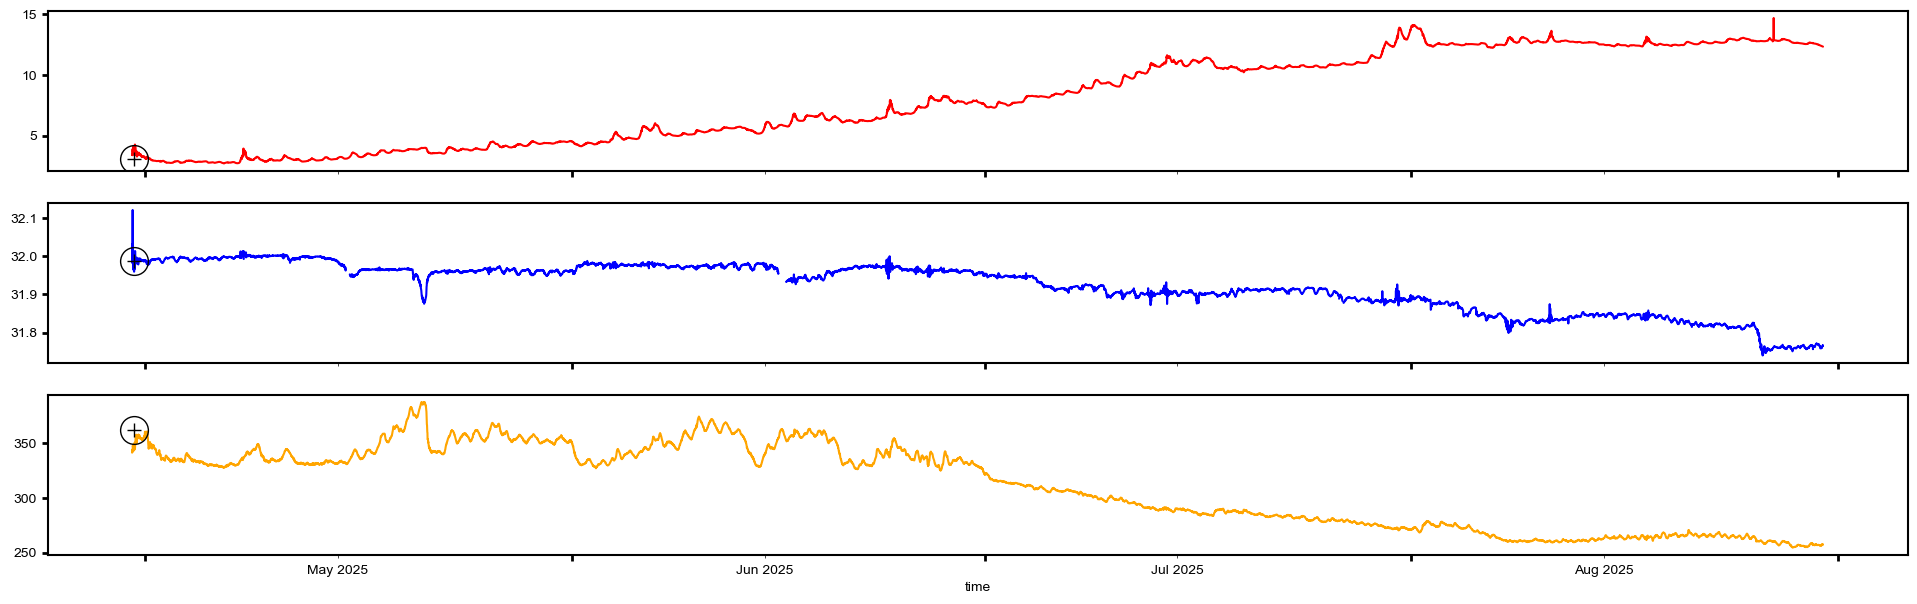

In [81]:
# depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])
depth = 5

fig, ax = plt.subplots(3,figsize=(24, 8),sharex=True)
df_cleaned_final.temperature.plot(ax=ax[0],color='r')
ax[0].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['T_28'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='black')
ax[0].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['T_28'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='black')
# ax[0].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
#         reccast[reccast['pressure'] == depth]['T_28'],
#         'o',markersize=20,markerfacecolor='none',markeredgecolor='black')
# ax[0].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
#         reccast[reccast['pressure'] == depth]['T_28'],
#         '+',markersize=10,markerfacecolor='none',markeredgecolor='black')

df_cleaned_final.salinity.plot(ax=ax[1],color='b')
ax[1].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['S_41'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='black')
ax[1].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['S_41'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='black')
# ax[1].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
#         reccast[reccast['pressure'] == depth]['S_41'],
#         'o',markersize=20,markerfacecolor='none',markeredgecolor='black')
# ax[1].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
#         reccast[reccast['pressure'] == depth]['S_41'],
#         '+',markersize=10,markerfacecolor='none',markeredgecolor='black')

df_cleaned_final.oxy_conc_umkg.plot(ax=ax[2],color='orange')
ax[2].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['O_65'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='black')
ax[2].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time']),
        depcast[depcast['pressure'] == depth]['O_65'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='black')
# ax[2].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
#         reccast[reccast['pressure'] == depth]['O_65'],
#         'o',markersize=20,markerfacecolor='none',markeredgecolor='black')
# ax[2].plot(pd.to_datetime(reccast[reccast['pressure'] == depth]['time']),
#         reccast[reccast['pressure'] == depth]['O_65'],
#         '+',markersize=10,markerfacecolor='none',markeredgecolor='black')

# xfmt = mdates.DateFormatter('%d-%b')
ax[2].xaxis.set_major_locator(DayLocator(bymonthday=1))
ax[2].xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax[2].xaxis.set_minor_formatter(DateFormatter('%b %Y'))
ax[2].xaxis.set_major_formatter(DateFormatter(''))
ax[2].xaxis.set_tick_params(which='major', pad=3)
ax[2].xaxis.set_tick_params(which='minor', pad=5)

fig.savefig(f"images/{file_name.replace('csv','_tempsalCal.png')}")

In [69]:
#print collocated cast comparison
mooring = sbe16_wop_nc.autotrim_time().sel(time=datetime.datetime.strptime(depcast['time'].unique()[0],
                                                                 '%Y-%m-%dT%H:%M:%SZ'),
                                 method='nearest')
print('Deployment')
print('T0:',mooring.temperature.values[0][0],depcast[depcast['pressure'] == depth]['T_28'].values)
print('T1:',mooring.temperature.values[0][0],depcast[depcast['pressure'] == depth]['T2_35'].values)
print('O0:',mooring.oxy_conc.values[0][0],depcast[depcast['pressure'] == depth]['O_65'].values,depcast[depcast['pressure'] == depth]['O_65'].values *1.0)
print('O1:',mooring.oxy_conc.values[0][0],depcast[depcast['pressure'] == depth]['CTDOXY_4221'].values,depcast[depcast['pressure'] == depth]['CTDOXY_4221'].values *1.0)
print('S0:',mooring.salinity.values[0][0],depcast[depcast['pressure'] == depth]['S_41'].values)
print('S1:',mooring.salinity.values[0][0],depcast[depcast['pressure'] == depth]['S_42'].values)

# mooring = sbe16_wop_nc.autotrim_time().sel(time=datetime.datetime.strptime(reccast['time'].unique()[0],
#                                                                  '%Y-%m-%dT%H:%M:%SZ'),
#                                  method='nearest')
# print('Recovery')
# print('T0:',mooring.temperature.values[0][0],reccast[reccast['pressure'] == depth]['T_28'].values)
# print('T1:',mooring.temperature.values[0][0],reccast[reccast['pressure'] == depth]['T2_35'].values)
# print('O0:',mooring.oxy_conc.values[0][0],reccast[reccast['pressure'] == depth]['O_65'].values,reccast[reccast['pressure'] == depth]['O_65'].values *1.034, 'W-312')
# print('O1:',mooring.oxy_conc.values[0][0],reccast[reccast['pressure'] == depth]['CTDOXY_4221'].values,reccast[reccast['pressure'] == depth]['CTDOXY_4221'].values *1.09, 'W-312')
# print('S0:',mooring.salinity.values[0][0],reccast[reccast['pressure'] == depth]['S_41'].values)
# print('S1:',mooring.salinity.values[0][0],reccast[reccast['pressure'] == depth]['S_42'].values)

Deployment
T0: [3.4455] [3.0896]
T1: [3.4455] [3.0937]
O0: [353.77099774] [361.68] [361.68]
O1: [353.77099774] [361.91] [361.91]
S0: [31.9685] [31.9865]
S1: [31.9685] [31.9807]


## Oxygen adjustment

In [5]:
oxy_offset = 1. #from winkler corrected CTD ~top bin

#saturation calculation
temp_oxysat = aand_oxy.o2_percent_sat(oxygen_conc=temp_oxycorr_umkg * oxy_offset,
                                           salinity=sbe16_wop_nc.get_xdf().salinity,
                                           temperature=sbe16_wop_nc.get_xdf().temperature,
                                           pressure=int(mooring_config['Instrumentation'][instrument]['ActualDepth']))


NameError: name 'aand_oxy' is not defined

In [ ]:
#add variables for us to save the datastream above
sbe16_wop_nc.add_variable(variable_names=['oxy_conc_umkg_ctdcor'],dupvar='oxy_conc_umkg')

#TODO: keep attributes when updating value
sbe16_wop_nc.add_external_data('oxy_conc_umkg_ctdcor',temp_oxycorr_umkg * oxy_offset)
sbe16_wop_nc.add_external_data('oxy_percentsat',temp_oxysat)

#add instrument global attributes (again) for new vars
sbe16_wop_nc.variable_meta_data(variable_keys=list(sbe16_wop_data.columns.values),drop_missing=False)
sbe16_wop_nc.variable_meta_data(variable_keys=['oxy_conc_umkg_ctdcor','oxy_percentsat'],drop_missing=True)


In [ ]:
###### combine trim (not mandatory) and filename together (saves to test.nc without name)

depth = str(int(mooring_config['Instrumentation'][instrument]['ActualDepth'])).zfill(4)
# mooring_yaml['Instrumentation'][self.instrument_id]['DesignedDepth'])).zfill(4) #<-- alternative
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'_'+depth+'m.nc'
sbe16_wop_nc.xarray2netcdf_save(xdf = sbe16_wop_nc.autotrim_time(),
                           filename=filename,format="NETCDF3_CLASSIC")

# don't trim the data and pass your own filename
# sbe16_wop_nc.xarray2netcdf_save(xdf = sbe16_wop_nc.get_xdf(),
#    filename=filename,format="NETCDF4_CLASSIC")